# **Simulation of Uncertainty-Aware Path Planning for Navigation on Road Networks Using Augmented MDPs**

**Course**:  AER1516 - Motion Planning for Robotics

**Professor**: Dr. Jonathan Kelly

**Date**: 24 March 2022

**Team**: Vishal Kanna Anand, Andrew Constantinescu, Sugumar Prabhakaran

**References**:  
[1]  L. Nardi and C. Stachniss, "Uncertainty-Aware Path Planning for Navigation on Road Networks Using Augmented MDPS," in *2019 International Conference on Robotics and Automation (ICRA)*, May 20-24, 2019, Montreal, Canada [Online]. Available: IEEE Xplore, https://ieeexplore.ieee.org/document/8794121. [Accessed: 01 March 2022].

[2]  O. Vysotska and C. Stachniss, "Improving SLAM by Exploiting Building Information from Publicly Available Maps and Localization Priors," PFG- Journal of Photogrammetry, Remote Sensing and Geoinformation Science, vol. 85, pp. 53-65, 21 February 2017. [Online]. Available:  Springer Link, https://link.springer.com/article/10.1007/s41064-017-0006-3.  [Accessed: 08 March 2022].

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## **Introduction**

This simulation is intended to verify the results from the paper by Nardi and Stachniss [1].  The paper proposes a way to incorporate localization uncertainty into path planning for navigation in road networks.  

This simulation will walk through step by step all the components from the paper to generate results.

## **Methodology**

### **Step 1. Localizability Map Z**

The paper uses the method proposed by Vysotska and Stachniss [2] to calculate the prior.  At each location of the map, a virtual scan is simulated by ray-casting the map.  

* Vysotska describes the result as a visiblity map based on OpenStreet Map (OSM) data. Need to specify function to measure the likelihood of obtaining a certain laser scan given a pose.

<p align='center'>
$p(z_j) ∼ N(c_j, \sigma_l)$
</p>

* each beam $z_j$ is independent of each other with its noise distributed as a gaussian. $c_j$ is the closest points in the building corresponding to endpoints of beam z_j.

<p align='center'>
<img src='https://drive.google.com/uc?export=view&id=1yXEME2jqbbNSgWXrAUcgCQCLh6gSy5fC'>
</p>

* A simulated scan is generated by ray-cast operation in the maps from OSM at every potential pose $x_i$ in the map.  Small perturbances to the pose $x_i = [x, y, \theta]$ are used to generate a set $S$.

* The error for a pose configuration is estimated using the sum of squared errors $e(z_j)$ of each individual beam ($z_j$) of the scan to the corresponding closest point on the building ($c_j$).  

<p align='center'>
$e(z_j) = (z_j - c_j)^2$
</p>

* The probability of taking a virtual measurement at a given configuration $x_j$ is is approximated as:

<p align='center'>
$p(x_j) = exp(-\frac{\sum e(z_j)}{2N\sigma_l^2})$
</p>

* Finally the covariance matrix (the uncertainty of the pose) is obtained as follows:

<p align='center'>
$cov(x_i) = \sum_{x_j \in S} p(x_j)(x_j-q_{xi})(x_j-q_{xi})^T$
</p>

In this case $q_{xi}$ is the coordinates of the query pose.

* **Output**:  The result is a covariance matrix (prior) for each traversable cell in X, known as the localizability map Z.


### **Step 2 - Augmented States (S)**

The set of augmented states is defined as follows:

$S = \{s=(v,\sigma^2)| v \in V, \sigma^2 \in W\}$

where:
* $s$: augmented state that is normally distributed: $s \sim N(v, \Sigma)$
* $V$: set of all road intersections
* $W$: set of all variances
*$\Sigma$: covariance matrix:  $\Sigma = \begin{bmatrix}
    \sigma^2 & 0 \\
    0 & \sigma^2
  \end{bmatrix}$

The augmented state s is defined over the discrete space $X$ as the probability mass function: $p(x|s)$

In [47]:
#vertices/ intersections
V = [(0.5, 0.5), (3.5, 0.5), (8.5, 0.5), (12.5, 0.5)]

# variances
var = [0, 1, 2, 0.5]

S = []
# augmented states
for i, v in enumerate(V):
    S.append((v, var[i]))

print("Set of Augmented States (S) =", S)

Set of Augmented States (S) = [((0.5, 0.5), 0), ((3.5, 0.5), 1), ((8.5, 0.5), 2), ((12.5, 0.5), 0.5)]


### **Step 3 - Actions (A)**

For our example, our action space ($A$) is only going to be defined as the four cardinal arrows:

$A = \{\uparrow,\downarrow, \leftarrow, \rightarrow \}$

### **Step 4 - Transition Function (T) Considering Position Uncertainty**

#### <u>Part 1 - Compute robot's position posterior starting at an intersection</u>

In part 1, we compute the robot's position posterior $p(x|v,a)$ without considering any uncertainty in the input position for all $v \in V$ and $a \in A$




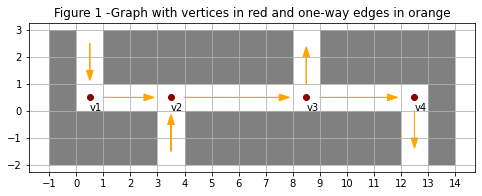

In [45]:
fig, ax = plt.subplots(figsize=(8,5))

# building layout
building1 = plt.Rectangle((1,1), 7, 2, fc='grey')
building2 = plt.Rectangle((4, -2), 8, 2, fc='grey')
building3 = plt.Rectangle((9,1), 5, 2, fc='grey')
building4 = plt.Rectangle((13,-2), 1, 3, fc='grey')
building5 = plt.Rectangle((-1,-2), 1, 5, fc='grey')
building6 = plt.Rectangle((0,-2), 3, 2, fc='grey')
plt.gca().add_patch(building1)
plt.gca().add_patch(building2)
plt.gca().add_patch(building3)
plt.gca().add_patch(building4)
plt.gca().add_patch(building5)
plt.gca().add_patch(building6)

# one-way streets
plt.arrow(0.5, 2.5, 0, -1, head_width=0.25, color='orange')
plt.arrow(8.5, 1, 0, 1, head_width=0.25, color='orange')
plt.arrow(3.5, -1.5, 0, 1, head_width=0.25, color='orange')
plt.arrow(12.5, 0, 0, -1, head_width=0.25, color='orange')
plt.arrow(1, 0.5, 1.5, 0, head_width=0.25, color='orange')
plt.arrow(4, 0.5, 3.5, 0, head_width=0.25, color='orange')
plt.arrow(9, 0.5, 2.5, 0, head_width=0.25, color='orange')

#vertices:
plt.scatter([0.5, 3.5, 8.5, 12.5], [0.5, 0.5, 0.5, 0.5], 
            c='darkred', marker='o')

intersections = ['v1', 'v2', 'v3', 'v4']
locations = [(0.5, 0),(3.5, 0), (8.5, 0), (12.5, 0)]
for i, location in enumerate(locations):
    plt.annotate(intersections[i], location)

plt.grid()
plt.xticks(np.arange(-1, 15))
plt.yticks(np.arange(-2,4))
plt.title('Figure 1 -Graph with vertices in red and one-way edges in orange')
plt.axis('scaled')
plt.show()